You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Data Fields
datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday  
workingday - whether the day is neither a weekend nor holiday  
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy  
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  
temp - temperature in Celsius  
atemp - "feels like" temperature in Celsius  
humidity - relative humidity  
windspeed - wind speed  
casual - number of non-registered user rentals initiated  
registered - number of registered user rentals initiated  
count - number of total rentals  

In [21]:
# Importing libraries


import os
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import gc
from sklearn.metrics import classification_report, make_scorer, mean_squared_error 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt


import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
import catboost as cb
import xgboost as xgb

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

plt.style.use('dark_background')

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings("ignore")

# 1. Loading and preprocessing data

In [2]:
# Loading data

df = pd.read_csv('train.csv')

In [3]:
df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# Let´s check duplicate values.

print(df.duplicated().sum())

0


In [5]:
# Let´s check for missing values.

df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [6]:
#split the column

df['datetime'] = pd.to_datetime(df['datetime'])

def ext(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek

In [7]:
ext(df)

In [8]:
df.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613,3.013963
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,0.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000,1.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000,3.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000,5.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000,6.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838,2.004585


# 2. EDA

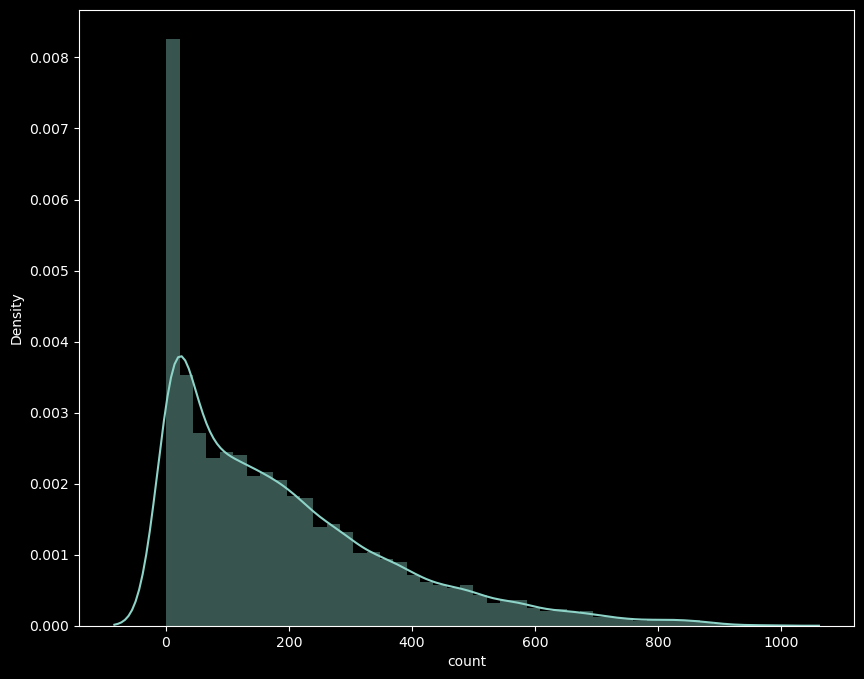

In [9]:
# Let´s check the distribution

fig = plt.figure(figsize=(10, 8))
sns.distplot(df['count'])
plt.show()

Our target is shifted to the right. A transformation may be needed. Let's continue EDA

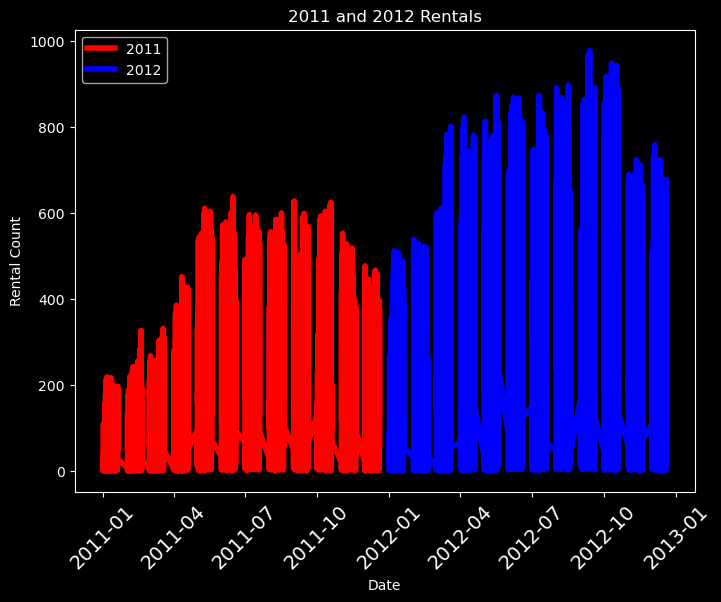

In [10]:
plt.figure(figsize=(8,6))
df_2011 = df[df['datetime'].dt.year == 2011]
df_2012 = df[df['datetime'].dt.year == 2012]

plt.plot(df_2011['datetime'], df_2011['count'], label='2011',color="red",lw=4)
plt.plot(df_2012['datetime'], df_2012['count'], label='2012',color="blue",lw=4)
plt.xticks(fontsize=14, rotation=45)
plt.xlabel('Date')
plt.ylabel('Rental Count')
plt.title('2011 and 2012 Rentals')
plt.legend()
plt.show()

We constructed a monthly distribution chart spanning several years. The trend indicates that in 2012, the number of rentals was much higher.

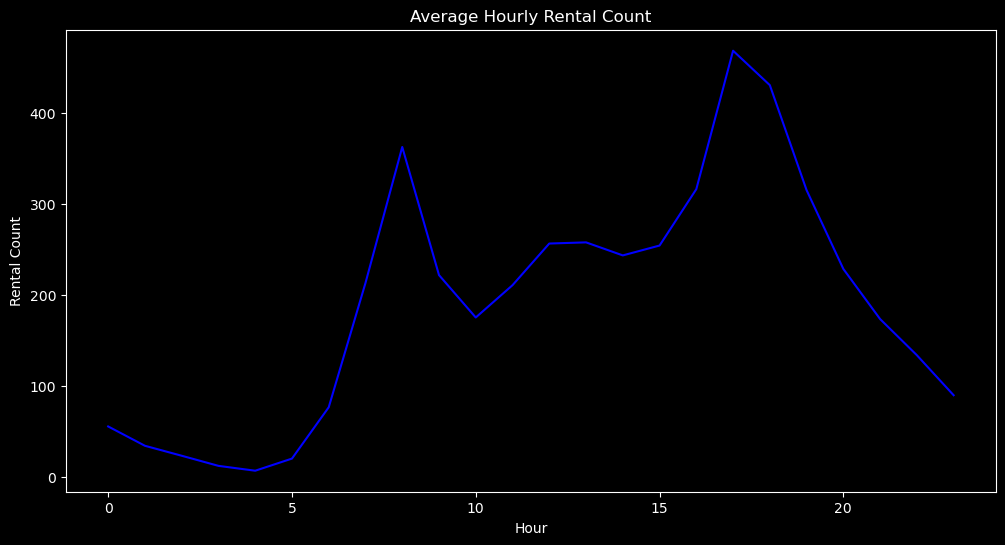

In [11]:
hour_g = df.groupby(['hour'])
avg_h = hour_g['count'].mean()

plt.figure(figsize=(12,6))

plt.plot(avg_h.index,avg_h,color="blue")

plt.xlabel('Hour')
plt.ylabel('Rental Count')

plt.title('Average Hourly Rental Count')
plt.show()

We constructed a graph to analyze the peak times for bike rentals. Our assessment reveals that rentals most frequently occur in the morning (before 10 a.m.) and in the evening (between 5 p.m. and 6 p.m.). This pattern may be attributed to individuals preferring to cycle to and from work.

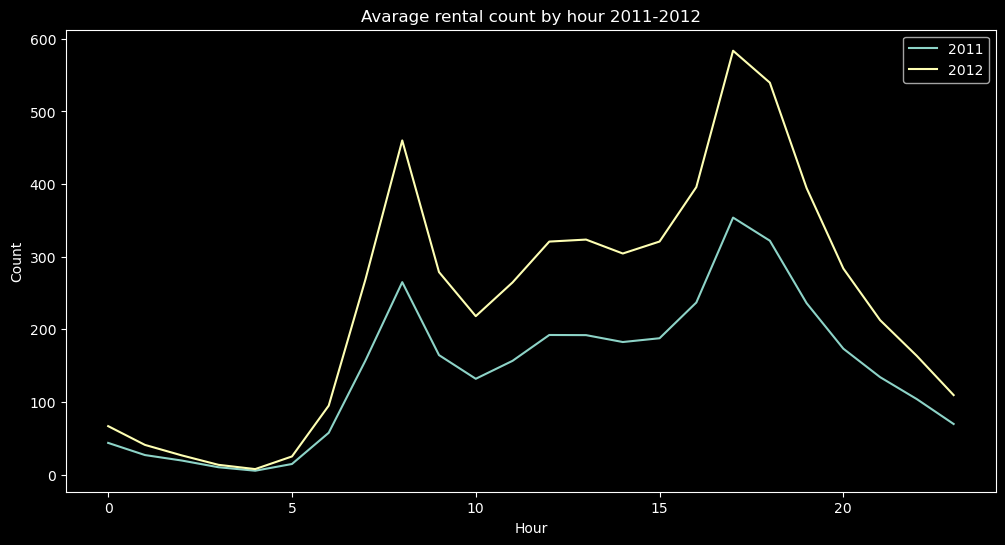

In [12]:
plt.figure(figsize=(12, 6))
y_h_group = df.groupby(['year', 'hour'])
avg_h = y_h_group['count'].mean()

plot = [plt.plot(avg_h[i].index, avg_h[i], label=i) for i in avg_h.index.levels[0]]

plt.legend()
plt.xlabel('Hour')
plt.ylabel('Count')

plt.title('Avarage rental count by hour 2011-2012')
plt.show()

Similar to the graph above, the trends in 2011 and 2012 are similar.

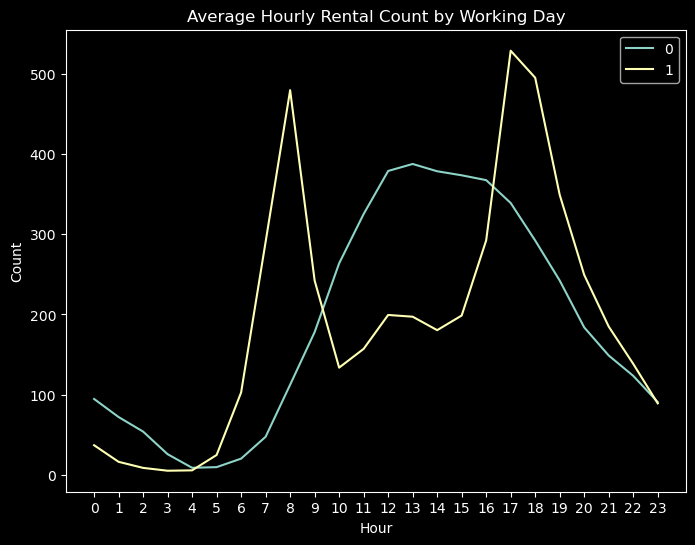

In [13]:
plt.figure(figsize=(8,6))
workingday_hour = df.groupby(['workingday','hour'])
avg_workingday_hour = workingday_hour['count'].mean()

plot_wd = [plt.plot(avg_workingday_hour[w].index,avg_workingday_hour[w],label=w) for w in avg_workingday_hour.index.levels[0]]
    
plt.legend()    
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))

plt.title('Average Hourly Rental Count by Working Day')
plt.show()

The graph above extends the earlier hypothesis that people ride bikes to and from work. On weekends and holidays, the most popular time for renting bikes is from 11 a.m. to 4 p.m.

In [14]:
#Let's check features for multicollinearity

corr = df.corr().round(2)
corr.style.background_gradient(cmap='coolwarm')

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
datetime,1.000000,0.480000,0.010000,-0.000000,-0.010000,0.180000,0.180000,0.030000,-0.090000,0.170000,0.310000,0.310000,0.870000,0.490000,0.030000,-0.010000,-0.000000
season,0.480000,1.000000,0.030000,-0.010000,0.010000,0.260000,0.260000,0.190000,-0.150000,0.100000,0.160000,0.160000,-0.000000,0.970000,0.000000,-0.010000,-0.010000
holiday,0.010000,0.030000,1.000000,-0.250000,-0.010000,0.000000,-0.010000,0.000000,0.010000,0.040000,-0.020000,-0.010000,0.010000,0.000000,-0.020000,-0.000000,-0.190000
workingday,-0.000000,-0.010000,-0.250000,1.000000,0.030000,0.030000,0.020000,-0.010000,0.010000,-0.320000,0.120000,0.010000,-0.000000,-0.000000,0.010000,0.000000,-0.700000
weather,-0.010000,0.010000,-0.010000,0.030000,1.000000,-0.060000,-0.060000,0.410000,0.010000,-0.140000,-0.110000,-0.130000,-0.010000,0.010000,-0.010000,-0.020000,-0.050000
temp,0.180000,0.260000,0.000000,0.030000,-0.060000,1.000000,0.980000,-0.060000,-0.020000,0.470000,0.320000,0.390000,0.060000,0.260000,0.020000,0.150000,-0.040000
atemp,0.180000,0.260000,-0.010000,0.020000,-0.060000,0.980000,1.000000,-0.040000,-0.060000,0.460000,0.310000,0.390000,0.060000,0.260000,0.010000,0.140000,-0.040000
humidity,0.030000,0.190000,0.000000,-0.010000,0.410000,-0.060000,-0.040000,1.000000,-0.320000,-0.350000,-0.270000,-0.320000,-0.080000,0.200000,-0.010000,-0.280000,-0.030000
windspeed,-0.090000,-0.150000,0.010000,0.010000,0.010000,-0.020000,-0.060000,-0.320000,1.000000,0.090000,0.090000,0.100000,-0.020000,-0.150000,0.040000,0.150000,-0.020000
casual,0.170000,0.100000,0.040000,-0.320000,-0.140000,0.470000,0.460000,-0.350000,0.090000,1.000000,0.500000,0.690000,0.150000,0.090000,0.010000,0.300000,0.250000


In [15]:
# Delete an unnecessary column

df.drop(columns="datetime",axis=1,inplace=True)

# 3. Modeling

In [16]:
features = df.drop(['count'], axis=1)
target = df['count']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.25, random_state=12345)

## 3.1 Сatboost

In [18]:
model_cb = cb.CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=10, loss_function='RMSE')

In [19]:
model_cb.fit(X_train, y_train)

0:	learn: 164.9551179	total: 156ms	remaining: 2m 36s
1:	learn: 150.5598800	total: 166ms	remaining: 1m 22s
2:	learn: 137.5444019	total: 175ms	remaining: 58.2s
3:	learn: 125.5009336	total: 185ms	remaining: 46s
4:	learn: 114.3967382	total: 194ms	remaining: 38.7s
5:	learn: 104.0614426	total: 204ms	remaining: 33.8s
6:	learn: 95.4060674	total: 213ms	remaining: 30.3s
7:	learn: 86.9969820	total: 223ms	remaining: 27.6s
8:	learn: 79.8487061	total: 232ms	remaining: 25.5s
9:	learn: 72.8340463	total: 241ms	remaining: 23.8s
10:	learn: 66.5654891	total: 250ms	remaining: 22.5s
11:	learn: 60.7494613	total: 259ms	remaining: 21.3s
12:	learn: 55.8469811	total: 264ms	remaining: 20.1s
13:	learn: 51.2967631	total: 273ms	remaining: 19.3s
14:	learn: 47.0306375	total: 283ms	remaining: 18.6s
15:	learn: 43.1204208	total: 293ms	remaining: 18s
16:	learn: 39.3432054	total: 303ms	remaining: 17.5s
17:	learn: 36.1471435	total: 313ms	remaining: 17.1s
18:	learn: 33.1882531	total: 322ms	remaining: 16.6s
19:	learn: 30.5168

175:	learn: 3.1489183	total: 1.84s	remaining: 8.64s
176:	learn: 3.1390247	total: 1.86s	remaining: 8.63s
177:	learn: 3.1291849	total: 1.87s	remaining: 8.62s
178:	learn: 3.1142071	total: 1.88s	remaining: 8.61s
179:	learn: 3.1007213	total: 1.89s	remaining: 8.6s
180:	learn: 3.0837383	total: 1.9s	remaining: 8.59s
181:	learn: 3.0707188	total: 1.91s	remaining: 8.58s
182:	learn: 3.0553277	total: 1.92s	remaining: 8.56s
183:	learn: 3.0426308	total: 1.93s	remaining: 8.55s
184:	learn: 3.0315148	total: 1.94s	remaining: 8.54s
185:	learn: 3.0221708	total: 1.95s	remaining: 8.53s
186:	learn: 3.0118313	total: 1.96s	remaining: 8.52s
187:	learn: 2.9991294	total: 1.97s	remaining: 8.51s
188:	learn: 2.9898741	total: 1.98s	remaining: 8.49s
189:	learn: 2.9770728	total: 1.99s	remaining: 8.48s
190:	learn: 2.9691460	total: 2s	remaining: 8.47s
191:	learn: 2.9581690	total: 2.01s	remaining: 8.45s
192:	learn: 2.9455356	total: 2.02s	remaining: 8.44s
193:	learn: 2.9342467	total: 2.03s	remaining: 8.42s
194:	learn: 2.919

350:	learn: 1.8972105	total: 3.53s	remaining: 6.54s
351:	learn: 1.8938914	total: 3.54s	remaining: 6.53s
352:	learn: 1.8896541	total: 3.55s	remaining: 6.51s
353:	learn: 1.8853077	total: 3.56s	remaining: 6.5s
354:	learn: 1.8815521	total: 3.57s	remaining: 6.49s
355:	learn: 1.8762412	total: 3.58s	remaining: 6.48s
356:	learn: 1.8724061	total: 3.59s	remaining: 6.47s
357:	learn: 1.8688652	total: 3.6s	remaining: 6.46s
358:	learn: 1.8637062	total: 3.61s	remaining: 6.45s
359:	learn: 1.8593881	total: 3.62s	remaining: 6.43s
360:	learn: 1.8554993	total: 3.63s	remaining: 6.42s
361:	learn: 1.8511448	total: 3.64s	remaining: 6.41s
362:	learn: 1.8459261	total: 3.65s	remaining: 6.4s
363:	learn: 1.8422609	total: 3.66s	remaining: 6.39s
364:	learn: 1.8402260	total: 3.67s	remaining: 6.38s
365:	learn: 1.8338466	total: 3.67s	remaining: 6.37s
366:	learn: 1.8308163	total: 3.68s	remaining: 6.36s
367:	learn: 1.8277601	total: 3.69s	remaining: 6.34s
368:	learn: 1.8222184	total: 3.7s	remaining: 6.33s
369:	learn: 1.81

527:	learn: 1.3479597	total: 5.19s	remaining: 4.64s
528:	learn: 1.3457299	total: 5.2s	remaining: 4.63s
529:	learn: 1.3439870	total: 5.21s	remaining: 4.62s
530:	learn: 1.3415894	total: 5.22s	remaining: 4.61s
531:	learn: 1.3389030	total: 5.23s	remaining: 4.6s
532:	learn: 1.3363973	total: 5.24s	remaining: 4.59s
533:	learn: 1.3346473	total: 5.25s	remaining: 4.58s
534:	learn: 1.3321242	total: 5.26s	remaining: 4.57s
535:	learn: 1.3303739	total: 5.27s	remaining: 4.56s
536:	learn: 1.3274834	total: 5.28s	remaining: 4.55s
537:	learn: 1.3256918	total: 5.29s	remaining: 4.54s
538:	learn: 1.3226139	total: 5.3s	remaining: 4.53s
539:	learn: 1.3198016	total: 5.31s	remaining: 4.52s
540:	learn: 1.3180779	total: 5.32s	remaining: 4.51s
541:	learn: 1.3144636	total: 5.33s	remaining: 4.5s
542:	learn: 1.3129274	total: 5.33s	remaining: 4.49s
543:	learn: 1.3111298	total: 5.34s	remaining: 4.48s
544:	learn: 1.3080912	total: 5.35s	remaining: 4.47s
545:	learn: 1.3060942	total: 5.36s	remaining: 4.46s
546:	learn: 1.30

701:	learn: 1.0224679	total: 6.87s	remaining: 2.92s
702:	learn: 1.0224226	total: 6.88s	remaining: 2.9s
703:	learn: 1.0208341	total: 6.89s	remaining: 2.9s
704:	learn: 1.0204202	total: 6.9s	remaining: 2.88s
705:	learn: 1.0203185	total: 6.91s	remaining: 2.88s
706:	learn: 1.0189848	total: 6.92s	remaining: 2.87s
707:	learn: 1.0183221	total: 6.92s	remaining: 2.85s
708:	learn: 1.0153538	total: 6.93s	remaining: 2.85s
709:	learn: 1.0143941	total: 6.94s	remaining: 2.83s
710:	learn: 1.0141441	total: 6.95s	remaining: 2.83s
711:	learn: 1.0134875	total: 6.96s	remaining: 2.82s
712:	learn: 1.0130211	total: 6.97s	remaining: 2.81s
713:	learn: 1.0118862	total: 6.98s	remaining: 2.8s
714:	learn: 1.0113219	total: 6.99s	remaining: 2.79s
715:	learn: 1.0100434	total: 7s	remaining: 2.78s
716:	learn: 1.0082897	total: 7.01s	remaining: 2.77s
717:	learn: 1.0063121	total: 7.03s	remaining: 2.76s
718:	learn: 1.0051014	total: 7.04s	remaining: 2.75s
719:	learn: 1.0028760	total: 7.05s	remaining: 2.74s
720:	learn: 0.99995

869:	learn: 0.8184769	total: 8.55s	remaining: 1.28s
870:	learn: 0.8172315	total: 8.56s	remaining: 1.27s
871:	learn: 0.8159923	total: 8.57s	remaining: 1.26s
872:	learn: 0.8146950	total: 8.58s	remaining: 1.25s
873:	learn: 0.8132076	total: 8.59s	remaining: 1.24s
874:	learn: 0.8121057	total: 8.6s	remaining: 1.23s
875:	learn: 0.8108803	total: 8.61s	remaining: 1.22s
876:	learn: 0.8089476	total: 8.62s	remaining: 1.21s
877:	learn: 0.8077111	total: 8.63s	remaining: 1.2s
878:	learn: 0.8071181	total: 8.63s	remaining: 1.19s
879:	learn: 0.8060400	total: 8.64s	remaining: 1.18s
880:	learn: 0.8050060	total: 8.65s	remaining: 1.17s
881:	learn: 0.8041704	total: 8.66s	remaining: 1.16s
882:	learn: 0.8025120	total: 8.67s	remaining: 1.15s
883:	learn: 0.8016178	total: 8.68s	remaining: 1.14s
884:	learn: 0.8006068	total: 8.69s	remaining: 1.13s
885:	learn: 0.7998347	total: 8.7s	remaining: 1.12s
886:	learn: 0.7988639	total: 8.71s	remaining: 1.11s
887:	learn: 0.7974050	total: 8.72s	remaining: 1.1s
888:	learn: 0.79

In [28]:
cb_predict = model_cb.predict(X_test)
mse = mean_squared_error(y_test, cb_predict)
rmse = sqrt(mse)
print('RMSE Catboost', rmse)

RMSE Catboost 5.267538414140287


## 3.2 Linear Regression 

In [30]:
model_lr = LinearRegression()

In [31]:
model_lr.fit(X_train, y_train)

LinearRegression()

In [39]:
scores = cross_val_score(model_lr, features, target, scoring='neg_mean_squared_error', cv=3)
rmse_scores = np.sqrt(-scores)

In [41]:
predict_lr = model_lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, predict_lr))
print('RMSE Linear regression', rmse_lr)

RMSE Linear regression 1.8260214183636266e-13


## 3.3 XGBoost 

In [49]:
regressor = xgb.XGBRegressor(max_depth = 10, n_estimators = 150)

In [50]:
regressor.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:128.20610	validation_1-rmse:126.52295
[1]	validation_0-rmse:90.53717	validation_1-rmse:89.62061
[2]	validation_0-rmse:64.02707	validation_1-rmse:63.56169
[3]	validation_0-rmse:45.36592	validation_1-rmse:45.14276
[4]	validation_0-rmse:32.22202	validation_1-rmse:32.22755
[5]	validation_0-rmse:22.97879	validation_1-rmse:23.16445
[6]	validation_0-rmse:16.53321	validation_1-rmse:16.90086
[7]	validation_0-rmse:12.04370	validation_1-rmse:12.63233
[8]	validation_0-rmse:8.88428	validation_1-rmse:9.82377
[9]	validation_0-rmse:6.68175	validation_1-rmse:8.01856
[10]	validation_0-rmse:5.12608	validation_1-rmse:6.84331
[11]	validation_0-rmse:3.99570	validation_1-rmse:6.04970
[12]	validation_0-rmse:3.20997	validation_1-rmse:5.57816
[13]	validation_0-rmse:2.64641	validation_1-rmse:5.26353
[14]	validation_0-rmse:2.24225	validation_1-rmse:5.10070
[15]	validation_0-rmse:1.94265	validation_1-rmse:5.00164
[16]	validation_0-rmse:1.68550	validation_1-rmse:4.96531
[17]	validation_0-rmse:

[143]	validation_0-rmse:0.04178	validation_1-rmse:4.84512
[144]	validation_0-rmse:0.04088	validation_1-rmse:4.84502
[145]	validation_0-rmse:0.03954	validation_1-rmse:4.84505
[146]	validation_0-rmse:0.03852	validation_1-rmse:4.84506
[147]	validation_0-rmse:0.03809	validation_1-rmse:4.84508
[148]	validation_0-rmse:0.03725	validation_1-rmse:4.84503
[149]	validation_0-rmse:0.03669	validation_1-rmse:4.84505


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [54]:
modelXGB = XGBRegressor(random_state = 42)
param_search = {'max_depth' : [3],
                'learning_rate' : [0.1],
                'n_estimators' : [500]
               }
gsearchXGB = GridSearchCV(estimator=modelXGB, cv=3,
                        param_grid=param_search,scoring = 'neg_root_mean_squared_error')
gsearchXGB.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [500]},
             scoring='neg_root_mean_squared_error')

In [55]:
gsearchXGB.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

In [57]:
predict_xgb = gsearchXGB.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, predict_xgb))
print('RMSE XGB', rmse_xgb)

RMSE XGB 4.64886957979718


As a result of training the Linear Regression, Catboost, XGBoost models, based on the RMSE indicator, we determined that the best forecasting model is the linear regression model. The indicator is close to zero, relative to other models, where the indicator ranges from 4 to 5.5